![](image.png)

### Deployment de Deep Learning com YOLO

In [0]:
# Use o mlflow para uma versão compatível
%pip install mlflow==2.21.3

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 67.6 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: mlflow-skinny
    Found existing installation: mlflow-skinny 3.4.0
    Uninstalling mlflow-skinny-3.4.0:
      Successfully uninstalled mlflow-skinny-3.4.0
  Attempting uninstall: mlflow
    Found existing installation: mlflow 3.4.0
    Uninstalling mlflow-3.4.0:
      Successfully uninstalled mlflow-3.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [0]:
# Instale a biblioteca necessária
%pip install ultralytics

  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
databricks-connect 16.4.2 requires numpy<2,>=1.15, but you have numpy 2.2.6 which is incompatible.
pyarrow 15.0.2 requires numpy<2,>=1.16.6, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Importe as bibliotecas necessárias
from ultralytics import YOLO

import mlflow.pyfunc
from mlflow.models.signature import infer_signature

import numpy as np
import pandas as pd
import base64
import io
from PIL import Image

In [0]:
# Carregue o modelo pré-treinado
model = YOLO("yolo11s.pt")

In [0]:
# Use a imagem da web como exemplo
import requests
image=requests.get("https://media.macphun.com/img/uploads/customer/blog/1355/15541861425ca2ff9ecf7899.00222453.jpg?q=85&w=850").content

from io import BytesIO
image_bytes = BytesIO(image)

from PIL import Image
image_pil = Image.open(image_bytes)

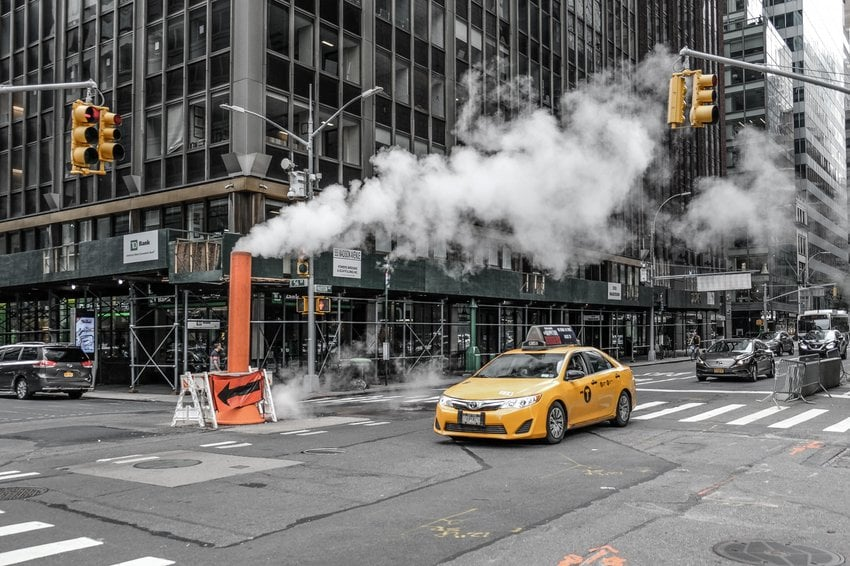

In [0]:
# Exiba a imagem
display(image_pil)


0: 448x640 1 person, 6 cars, 1 bus, 5 traffic lights, 831.9ms
Speed: 10.0ms preprocess, 831.9ms inference, 33.6ms postprocess per image at shape (1, 3, 448, 640)


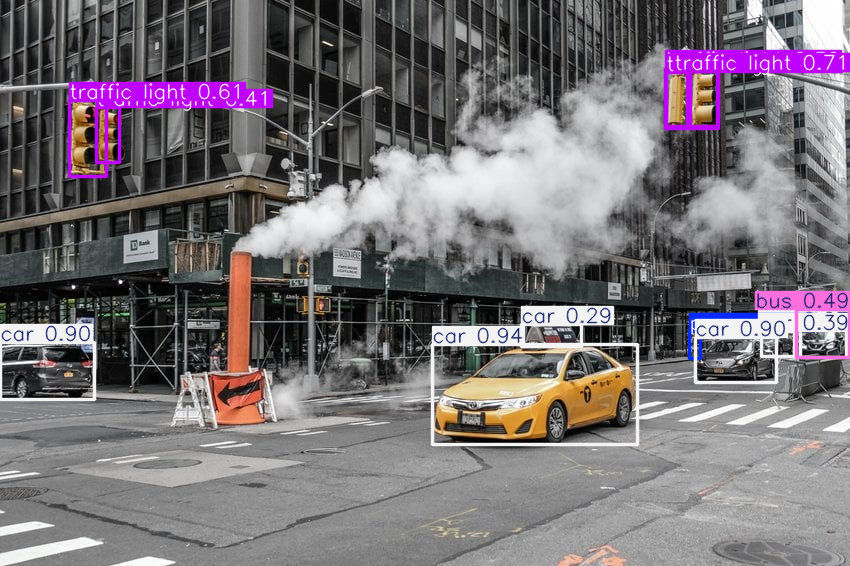

In [0]:
results = model([image_pil])  # Usa o array numpy

# Crie os resultados para cada objeto identificado
for result in results:
    boxes = result.boxes
    masks = result.masks
    keypoints = result.keypoints
    probs = result.probs
    obb = result.obb
    result.show()

In [0]:
# Crie um wrapper
class YoloWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.model = YOLO(context.artifacts["model_path"])

    def predict(self, context, model_input):

        # Suporta DataFrame ou dicionário
        if hasattr(model_input, 'iloc'):
            b64 = model_input.iloc[0]['image_base64']
        else:
            b64 = model_input['image_base64']

        # Decodifica base64 em bytes
        img_bytes = base64.b64decode(b64)
        image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        image_np = np.array(image)
        
        # Faz predição
        results = self.model(image_np)

        # Salva a imagem anotada em memória
        output_buffer = io.BytesIO()

        # YOLO .plot()
        annotated_img = results[0].plot() if hasattr(results[0], "plot") else results[0].imgs[0]
        annotated_pil = Image.fromarray(annotated_img)
        annotated_pil.save(output_buffer, format="JPEG")
        output_b64 = base64.b64encode(output_buffer.getvalue()).decode("utf-8")
        return {"predicted_image_base64": output_b64}

# Crie um arquivo temporário
temp_path = "/tmp/yolo11s.pt"
model.save(temp_path)

# Crie um input de exemplo
img_url = "https://cdn.pixabay.com/photo/2020/04/09/10/47/car-5020870_1280.jpg"

# Baixe e codifique a imagem em base64
img_response = requests.get(img_url)
b64_img = base64.b64encode(img_response.content).decode("utf-8")

input_example = pd.DataFrame({
    "image_base64": [b64_img]
})

# Exemplo de saída para signature
predicted_example = pd.DataFrame({"predicted_image_base64": ["exemplo_base64"]})
signature = infer_signature(input_example, predicted_example)

with mlflow.start_run() as run:
    mlflow.pyfunc.log_model(
        artifact_path="model", 
        python_model=YoloWrapper(),
        artifacts={"model_path": temp_path},
        pip_requirements=["ultralytics", "pillow", "numpy"],
        input_example=input_example,
        signature=signature
    )


/databricks/python/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/09/24 18:34:14 INFO mlflow.pyfunc: Validating input example against model signature



0: 448x640 1 person, 2 cars, 2 potted plants, 510.9ms
Speed: 23.0ms preprocess, 510.9ms inference, 30.2ms postprocess per image at shape (1, 3, 448, 640)


In [0]:
# Abra a execução do MLflow, registre o modelo (de preferência sempre no Unity Catalog - basta colocar o nome que deseja e clicar em Register). Em seguida, sirva o modelo. Conforme abaixo

![YOLORegistry.png](./YOLORegistry.png "YOLORegistry.png")

![YOLOUC.png](./YOLOUC.png "YOLOUC.png")

![endpointYOLO.png](./endpointYOLO.png "endpointYOLO.png")

Digite seu token:  [REDACTED]

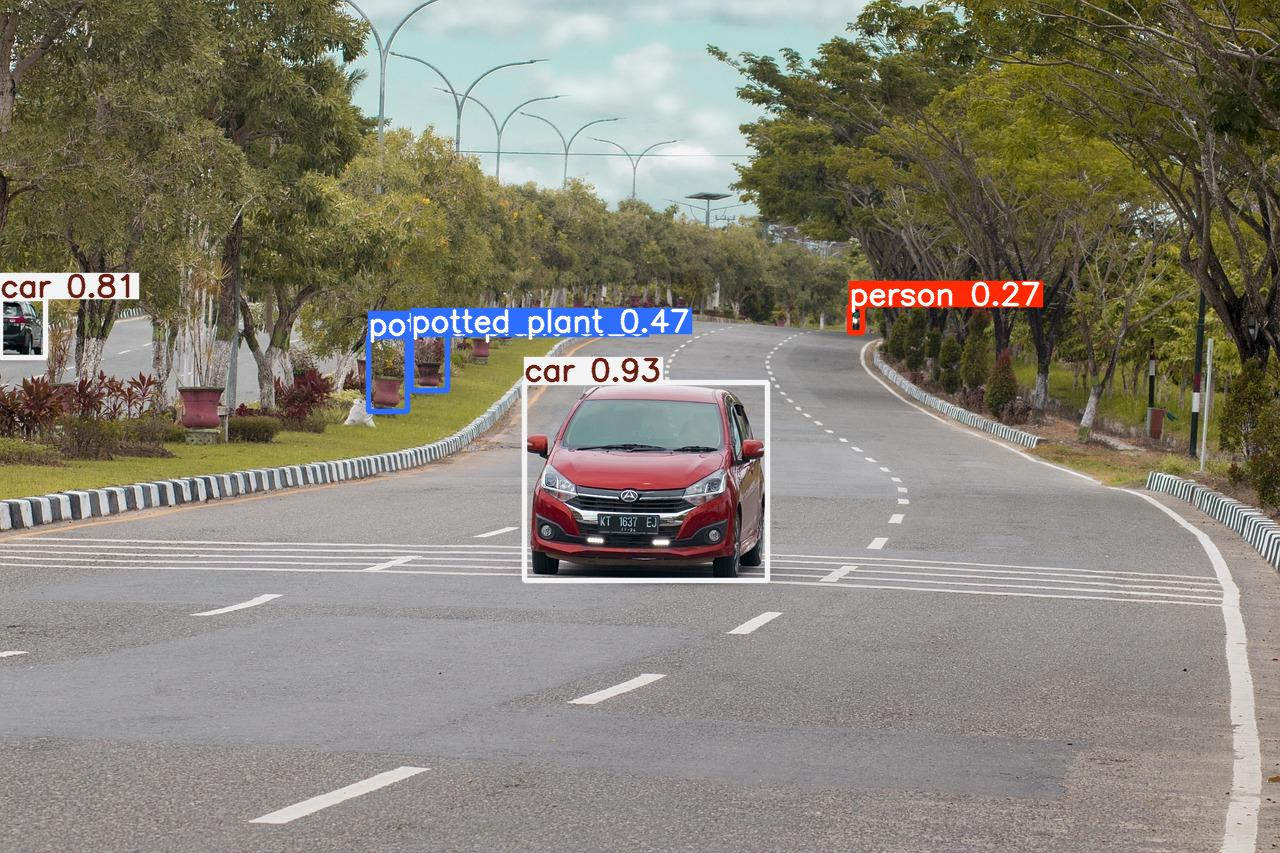

In [0]:
import requests
import base64
import json
from PIL import Image
from io import BytesIO
import getpass

# Insira o token
token = getpass.getpass("Digite seu token: ")

# URL da imagem pública
img_url = "https://cdn.pixabay.com/photo/2020/04/09/10/47/car-5020870_1280.jpg"

# Baixa e codifica a imagem em base64
img_response = requests.get(img_url)
b64_img = base64.b64encode(img_response.content).decode("utf-8")

payload = {
    "dataframe_split": {
        "columns": ["image_base64"],
        "data": [[b64_img]]
    }
}

headers = {
    "Authorization": f"Bearer {token}",  # Substitua pelo seu token
    "Content-Type": "application/json"
}

url = "https://e2-demo-field-eng.cloud.databricks.com/serving-endpoints/yoloendpointtestebaraldi/invocations"

response = requests.post(url, headers=headers, data=json.dumps(payload))
result = response.json()

# O campo retornado contém a imagem anotada em base64
display(Image.open(BytesIO(base64.b64decode(result["predictions"]["predicted_image_base64"]))))

### Deployment com GenAI Multimodal com Modelo na Plataforma da Databricks

In [0]:
# Instale as bibliotecas necessárias
%pip install langchain-community langchain-core databricks-langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.5/717.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.6/948.6 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.2
    Not uninstalling requests at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-539a7227-edbe-49fc-bb1e-65618db36995
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: databricks-sdk
    Found existing installation: databricks-sdk 0.49.0
    Not uninstalling dat

In [0]:
# Importe as bibliotecas necessárias
import base64
from langchain_core.messages import SystemMessage, HumanMessage
from databricks_langchain import ChatDatabricks
import getpass
import mlflow.langchain
from io import BytesIO
from langchain_core.prompts.chat import ChatPromptTemplate
import requests
from PIL import Image

In [0]:
# Ative o autolog
mlflow.langchain.autolog()


# Baixe e processe a imagem
img_url = "https://cdn.pixabay.com/photo/2020/04/09/10/47/car-5020870_1280.jpg"
img_response = requests.get(img_url)
img = Image.open(BytesIO(img_response.content)).convert("RGB")
img = img.resize((224, 224))
buffer = BytesIO()
img.save(buffer, format="JPEG", quality=70)
buffer.seek(0)
img_base64 = base64.b64encode(buffer.read()).decode("utf-8")

# Crie o template multimodal conforme documentação
template = ChatPromptTemplate.from_messages(
    [
        ("system", "Você é um assistente que conta carros em imagens."),
        (
            "human",
            [
                {"type": "text", "text": "Quantos carros existem na imagem?"},
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{img_base64}",
                },
            ],
        ),
    ]
)

# Gere os prompts/mensagens no formato correto
messages = template.format_messages()

# Inicialize o modelo Databricks via LangChain
llm = ChatDatabricks(endpoint="databricks-llama-4-maverick")

with mlflow.start_run(run_name="inferência_multimodal"):
    resposta = llm.invoke(messages)

    # Salve a resposta como um artefato do MLflow
    mlflow.log_dict({"resultado": str(resposta)}, "resultado.json")
    resposta

Trace(request_id=tr-6b497ff7018d45d2a8270e46ed87db07)